In [10]:
import xarray as xr
from metpy.units import units
import metpy
import metpy.calc as mpcalc
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import json

In [11]:
from credit.interp import create_reduced_pressure_grid, geopotential_from_model_vars,interp_hybrid_to_height_agl

In [12]:
    
def temp_profile(ds_path, time_stamp):
    ds = xr.open_zarr(ds_path, consolidated=True).sel(time = [time_stamp])
    model_params_path = "/glade/work/sakor/miles-credit/credit/metadata/ERA5_Lev_Info.nc"
    surface_geopotential_path = "/glade/campaign/cisl/aiml/credit/static_scalers/static_whole_20250416.nc"
    interp_heights_m =  np.arange(0, 5250, 250)
    levels = np.array([10, 30, 40, 50, 60, 70, 80, 90, 95, 100, 105, 110, 120, 130, 136, 137])
    model_params = xr.open_dataset(model_params_path)
    surface_geopotential_ds = xr.open_dataset(surface_geopotential_path)
    surface_geopotential = surface_geopotential_ds.Z_GDS4_SFC.values
    
    time_values = ds.time.values 
    hgl_data = {}
    for t_idx in range(len(time_values)):
        lat, lon = ds.latitude.values, ds.longitude.values
        # Compute 3D pressure for current time step
        pressure_3d, pressure_3d_half = create_reduced_pressure_grid(
            ds.SP.values,
            model_params.a_model.sel(level=levels).values,
            model_params.b_model.sel(level=levels).values
        )
        
        # Compute geopotential height
        model_geopotential = geopotential_from_model_vars(
            surface_geopotential,
            ds.SP.isel(time=t_idx).values.astype(np.float64),
            ds.T.isel(time=t_idx).values.astype(np.float64),
            ds.Q.isel(time=t_idx).values.astype(np.float64),
            pressure_3d_half[0].astype(np.float64)
        )
        
        d_interp = interp_hybrid_to_height_agl(
                        ds['T'].isel(time=t_idx).values,
                        interp_heights_m,  
                        model_geopotential,
                       surface_geopotential
                    )
        d_interp -= 273.15
        hgl_data['t_h'] = (
                            ['time', 'height', 'latitude', 'longitude'],
                            np.empty((len(time_values), len(interp_heights_m), len(lat), len(lon)))
                        )
        hgl_data['t_h'][1][t_idx, ...] = d_interp
        
    df_t = xr.Dataset(
                hgl_data,
                coords={
                    'time': (['time'], time_values),
                    'height': (['height'], interp_heights_m),
                    'latitude': (['latitude'], lat),
                    'longitude': (['longitude'], lon)
                }
            )
    return df_t['t_h']

In [22]:
def qc_mping(ds_path, json_data,timestamp, snow_thresh=3, rain_thresh=-1, other_thresh=0, temp_crossings=(1, -2)):
    
    ds = xr.open_zarr(ds_path, consolidated=True).sel(time = [timestamp])
    
    ds['t2m'].attrs['units'] = 'kelvin'
    
    # Compute dew point temperature in degC
    dewpoint_2m = mpcalc.dewpoint_from_specific_humidity(
        ds['SP'] * units.pascal,
        ds['Q'].isel(level=-1) * units.kilogram / units.kilogram,
    )
    
    ds['d2m'] = dewpoint_2m
    ds['d2m'].attrs['units'] = 'degC'
    ds['d2m'].attrs['long_name'] = '2m Dew Point Temperature'

    # MPING classification function
    def classify_precip(description):
        desc = description.lower()
        if "freezing drizzle" in desc or "freezing rain" in desc:
            return "Freezing Rain"
        elif "drizzle" in desc or "rain" in desc:
            return "Rain"
        elif "snow" in desc or "graupel" in desc:
            return "Snow"
        elif "sleet" in desc or "ice pellets" in desc:
            return "Ice Pellets"
        else:
            return "Other"

    mping = []
    for obs in json_data:
        lon, lat = obs["geom"]["coordinates"]
        ptype = classify_precip(obs["description"])
            
        # calculate surface wetbulb temp:
        T2m = ds['t2m'].sel(
                latitude=lat,
                longitude=lon,
                method='nearest'
            ).metpy.convert_units('degC')  
        D2m = ds['d2m'].sel(
                latitude=lat,
                longitude=lon,
                method='nearest'
            ).metpy.convert_units('degC')  
        SP = ds['SP'].sel(
                latitude=lat,
                longitude=lon,
                method='nearest'
            ).metpy.convert_units('hPa')  # Assuming the pressure is in Pa, convert to hPa
        
        # Ensure the data has units attached
        
        T2m = T2m.metpy.quantify()
        D2m = D2m.metpy.quantify()
        SP = SP.metpy.quantify()
        wbulb = metpy.calc.wet_bulb_temperature(SP.values* units.hPa, T2m.values* units.degC, D2m.values* units.degC).to('degC').magnitude 

        if ptype == 'Snow':
            if np.any(wbulb < snow_thresh):
                mping.append(obs)
        elif ptype == 'Rain':
            if np.any(wbulb > rain_thresh):
                mping.append(obs)
        elif ptype == 'Freezing Rain' or ptype == 'Ice Pellets/Sleet':
            # check if temp crosses 0 celsius at least once.
            m = temp_profile(ds_path, timestamp).sel(latitude=lat,longitude=lon,method='nearest').isel(time = 0).values
            # print(m)
            within_range = np.any(m > temp_crossings[0]) & np.any(m < temp_crossings[1])
            print(within_range, wbulb)
            # at least one temp crossing and mping[filter] one temp crossing across all height levels
            if within_range and np.any(wbulb) < other_thresh:
                mping.append(obs)
    return mping

In [23]:
ds_path = '/glade/campaign/cisl/aiml/credit/era5_zarr/y_TOTAL_2021-01-01_2021-12-31_staged.zarr'
timestamp = '2021-02-13T17'


path_2_mping_json='/glade/campaign/cisl/aiml/ai2es/winter_ptypes/mping_hourly/mping_raw2021-02-13_18:00:00.json'
with open(path_2_mping_json) as f:
    json_data = json.load(f)

In [24]:
mping = qc_mping(ds_path, json_data,timestamp)

True 11.739538450542796
True 12.768403181617828
True 12.541894126281989
True 10.084086153504416
True 11.885228314987216
True 12.768403181617828
True 11.885228314987216
True 11.739538450542796
True 12.004173995005829
True 11.885228314987216
True 11.653992315424375
True 12.541894126281989
True 12.541894126281989
True 12.659364279382771
True 12.659364279382771
True 11.653992315424375
True 11.885228314987216
True 11.885228314987216
True 11.885228314987216
True 11.885228314987216
True 11.653992315424375
True 12.871808025780581
True 12.541894126281989
True 11.653992315424375
True 11.653992315424375
True 11.885228314987216


In [16]:
import json
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cartopy.io.shapereader import natural_earth
# import xesmf as xe
import cfgrib


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [17]:
 
# Custom purple colormap
def mping_class(ax,json_data,extent):
    custom_colors = ['#f8f4f8', '#f005fc']
    purples = mcolors.LinearSegmentedColormap.from_list("custom", custom_colors)
    
    # Classification function
    def classify_precip(description):
        desc = description.lower()
        if "freezing drizzle" in desc or "freezing rain" in desc:
            return "Freezing Rain"
        elif "drizzle" in desc or "rain" in desc:
            return "Rain"
        elif "snow" in desc or "graupel" in desc:
            return "Snow"
        elif "sleet" in desc or "ice pellets" in desc:
            return "Ice Pellets"
        else:
            return "Other"
    
    # Grouping coordinates
    grouped_points = defaultdict(list)
    for obs in json_data:
        label = classify_precip(obs["description"])
        lon, lat = obs["geom"]["coordinates"]
        grouped_points[label].append((lon, lat))
    
    # Assign colormaps to classes
    colormap_dict = {
        "Rain": plt.colormaps["Greens"],
        "Snow": plt.colormaps["Blues"],
        "Freezing Rain": plt.colormaps["Reds"],
        "Ice Pellets": plt.colormaps['Purples']
    }
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Plot each group with a distinct color from its colormap
    for i, (label, coords) in enumerate(grouped_points.items()):
        lons, lats = zip(*coords)
        cmap = colormap_dict.get(label, plt.cm.gray)
        color = cmap(0.7)  # pick mid-shade
        ax.scatter(
            lons, lats,
            color=color,
            label=label,
            s=40,
            transform=ccrs.PlateCarree(),
            edgecolor='k', linewidth=0.3,
        )
    
    ax.legend(title="Precip Class", loc="lower left", fontsize="small")
    plt.title("Precipitation Types with Custom Colormaps")
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08)
    plt.show()


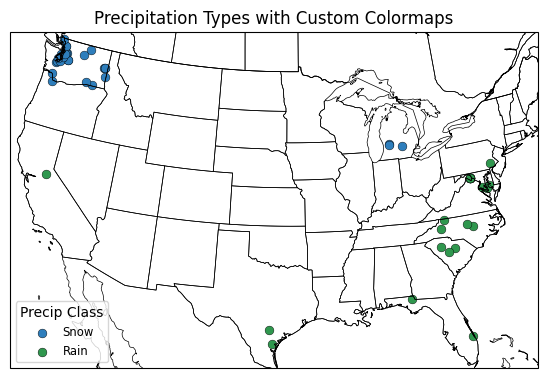

In [18]:
fig, ax = plt.subplots(
        figsize=(6, 4),
        subplot_kw={'projection': ccrs.LambertConformal()}
    )

mping_class(ax,mping, [-120, -75, 26, 50])